# Esercitazione 9
### Laboratorio di Simulazione Numerica

Il materiale relativo all'esercitazione nove è conservato nella cartella `Lab_09`. Il codice si trova in `Code/9.1` e i risultati ottenuti sono raccolti nella cartella `Results`.

---

Il Jupyter Notebook è organizzato nel modo seguente:
- 9.0 caricamento dei pacchetti e introduzione;
- 9.1 un algoritmo genetico per risolvere il problema del "commesso viaggiatore".

## 9.0 - caricamento dei pacchetti e introduzione

In questa esercitazione abbiamo costruito un algoritmo genetico e lo abbiamo utilizzato per cercare una soluzione al problema del commesso viaggiatore (_Traveling Salesman Problem_, aka TSP), nel quale si considera un sistema di punti nello spazio (nel nostro caso i punti sono città disposte casualmente su un piano) e si cerca il percorso più breve durante il quale il commesso passa per ogni città una volta sola. 

---

Gli algoritmi genetici (GAs) simulano i processi di selezione naturale ed evoluzione biologica per cercare soluzioni in problemi di ottimizzazione. Per discutere in modo scorrevole dei GAs è necessario introdurre qualche notazione. Chiameremo:
- __cromosoma:__ una possibile soluzione al problema. Essa contiene una serie di elementi che la costituiscono e che, in analogia con la genetica, chiamiamo __geni__;
- __popolazione:__ l'insieme dei cromosomi ad un certo tempo $t$, che indicheremo con $N_{pop}$ e fisseremo ad un certo valore nelle simulazioni. In termini computazionali, definiamo in questo modo l'insieme dei cromosomi considerati all'interno di una __generazione__ (un GA viene eseguito per un certo numero di generazioni, esattamente come ci aspettiamo si comporti il processo evolutivo in una specie).

Il processo di evoluzione genetica viene implementato tramite tre diversi tipi di operatore:
1. __operatore di selezione naturale:__ in natura sono gli individui più forti ad avere una maggior probabilità di riprodursi: il pavone con la livrea più affascinante, il leone più forte del gruppo, eccetera. Serve dunque un operatore che selezioni con maggior probabiltà gli elementi corrispondenti a soluzioni migliori al problema;
2. __operatore di crossover:__ un passo cruciale nella costruzione di una nuova generazione di individui è il crossover, cioè il risultato della riproduzione di due individui (tipicamente due individui forti). Abbiamo necessità di un operatore in grado di implementare la costruzione di cromosomi "figli" a partire dall'incrocio di due cromosomi "genitori";
3. __operatore di mutazione:__ nella generazione $(i+1)$-esima, ottenuta generando un numero $N_{pop}$ di individui a partire dalla popolazione corrispondente alla generazione $i$-esima, capita in natura che si verifichino delle mutazioni. Queste portano un contributo fondamentale alla ricerca casuale della soluzione ottima (dell'individuo più forte possibile).

Eseguendo dunque un processo di "ricambio generazionale" che calchi le orme dei processi di selezione naturale siamo in grado di simulare l'evoluzione di una popolazione e proporre soluzioni sempre migliori al problema di riferimento. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode

sns.set_theme(font_scale=1.5, style='whitegrid')

In [12]:
cities = np.loadtxt("Results/circle_circuit.dat")

chromo1 = np.loadtxt("Results/circle_initial.dat", dtype='int')
chromo2 = np.loadtxt("Results/circle_final.dat", dtype='int')
square1 = np.loadtxt("Results/square_initial.dat", dtype='int')
square2 = np.loadtxt("Results/square_final.dat", dtype='int')

best_cir = np.loadtxt("Results/best_cir.dat")
half_cir = np.loadtxt("Results/best_half_cir.dat")

best_sq = np.loadtxt("Results/best_sq.dat")
half_sq = np.loadtxt("Results/best_half_sq.dat")

## 9.1 - Un algoritmo genetico per risolvere il problema del commesso viaggiatore 

Come spiegato in precedenza, un algoritmo genetico si costituisce di un certo numero di elementi specifici, i quali vengono implementati nel modo opportuno all'interpretazione del problema che siamo interessati a risolvere. In questo caso, ci occupiamo del problema del commesso viaggiatore. 

---

Assumiamo che ci sia un commesso viaggiatore che ha il compito di visitare un certo numero $N$ di città. Vogliamo che le visiti tutte, senza mai passare due volte per lo stesso punto e percorrendo la strada più breve possibile. Nel corso dell'esercizio abbiamo considerato $N=32$ città disposte: (A) casualmente lungo una circonferenza di raggio $r=1$, (B) casualmente all'interno di un quadrato di lato $l=1$. Per valutare l'efficienza di un certo percorso proposto utilizziamo una funzione di costo corrispondente alla somma delle distanze che separano le città disposte in modo consecutivo all'interno della sequenza:
$$ L = \sum_{i=1}^{32} d(C_i, C_{i+1}), \qquad \text{con}\qquad d(C_i,C_{j})=\sqrt{\sum_{k=1}^2 \bigl(x_k^{(j)}-x_k^{(i)}\bigr)^2}, $$
dove con $x_k^{(i)}$ ho indicato la coordinata $k$ della $i$-esima città e coinvolgiamo nel conto anche il ponte tra la città in posizione 32 e quella in posizione 1.
Per risolvere il problema del commesso viaggiatore ho scritto la classe `Salesman`, presentata in: `TSP.cpp/h`. Nelle righe seguenti spiego le scelte che ho adottato:

#### Generare le città

ho scritto due metodi: `generate_cities_on_circle` e `generate_cities_in_square` all'interno della classe `Random`, tramite i quali genero le città in modo casuale secondo le indicazioni fornite e ne salvo le coordinate 2D in un file. Questa scelta è strettamente legata al metodo che ho deciso di adottare per il calcolo del costo di ciascun cromosoma, che spiego poco più avanti.

#### Spiegazione delle strutture dati utilizzate 

- __cromosoma__: come cromosoma ho definito una variabile di tipo `struct Chromo`, contenente quattro elementi: la dimensione del cromosoma (numero di città) `Chromo.size=N`, la città da cui il commesso inizia il suo viaggio, corrispondente all'identificativo numero uno: `Chromo.head=1` (che è la prima generata dalle funzioni esposte al punto precedente). Ogni cromosoma contiene inoltre un `vector<int>` di interi di dimensione `N-1`, definito come `Chromo.tail`, nel quale viene salvata una sequenza di possibili scelte consecutive nella visita alle città diverse dalla uno e una variabile in cui salvo il costo del cromosoma `Chromo.cost`; Ho deciso di adottare questa scelta, che è una lieve modifica alla rappresentazione 1D presentata a lezione, perché mi permette di eseguire le mutazioni genetiche su `Chromo.tail`, evitando il pericolo di modificare il punto di partenza e di arrivo del commesso viaggiatore. I __geni__, come intuibile dalla spiegazione delle struttura dei cromosomi, sono dei numeri interi, identificativi delle città generate come spiegato in precedenza;
- il __commesso viaggiatore__ è interpretato dalla classe `Salesman`. Tra i _data members_ della classe cito: due puntatori a vettore di cromosomi: `Chromo *_pop` e `Chromo *_son`, corrispondenti alla vecchia e alla nuova generazione di soluzioni e una matrice bidimensionale: `_prices`, di dimensione $N\times N$ (nel caso in esame $32 \times 32$), dove con $N$ indico il numero di città da visitare.

#### La valutazione del costo di un cromosoma

Per svolgere questa operazione ho deciso di investire complessità in spazio per risparmiare complessità in tempo. Ho infatti deciso di salvare nella matrice `_prices` tutte le distanze esistenti nel tracciato. Si tratta di una matrice $32\times 32$, in cui, per esempio, selezionando l'elemento `_prices[i][j]` si accede al valore della distanza che separa le città rappresentate rispettivamente dagli identificativi `(i+1)` e `(j+1)`.  

Ho scelto di procedere in questo modo nella consapevolezza che tale scelta risulta ragionevole in questo caso, nel quale stiamo considerando un numero molto basso di città. Al contrario, il numero di volte in cui è necessario calcolare il costo di un cromosoma è decisamente superiore. Ho deciso di pagare ogni volta il costo d'accesso e non quello di calcolo. Nel caso in cui il problema avesse coinvolto un numero molto maggiore di città avrei scelto di ricalcolare ogni volta il costo della distanza tra due città, evitando di impegnare molta memoria.

In accordo con questa mia scelta, il processo tramite cui valuto il costo di ciascun cromosoma è il seguente:
1. inizializzo `costo = 0`;
2. aggiungo al costo la distanza tra la testa e il primo elemento della coda;
3. aggiungo al costo la distanza tra la testa e l'ultimo elemento della coda;
4. calcolo le $N-2$ distanze rimanenti, corrispondenti agli elementi `Prices[chromosome.tail.at(i)-1][chromosome.tail.at(i+1)-1]` (devo sottrarre ogni volta 1 perché le città sono identificate dai valori $[1,..., 32]$ mentre le posizioni nelle strutture dati partono da zero).

#### Gli operatori dell'algoritmo genetico

Come ultima cosa, spiego quali scelte ho adottato nell'implementazione del processo di selezione naturale. Partiamo da un numero $N_{pop}$ di individui, ciascuno dei quali corrisponde ad un cromosoma nel quale la coda (contenente i valori $n\in[2,32]$) viene rimescolata utilizzando il metodo `permute_chromo`, che si basa sulla funzione `random_shuffle` fornita dalla libreria `<algorithm>`. La popolazione viene ordinata in modo che l'individuo migliore (costo minimo) si trovi nella posizione zero e il peggiore (costo massimo) nella $N_{pop}-1$.

- per prima cosa occorre __selezionare__ due genitori nella popolazione. Per farlo ho utilizzato il metodo `select_from_pop`, appartenente alla classe `Random`, nel quale l'indice $i$ dell'individuo che si riproduce viene proposto nel modo seguente: $$ i = N_{pop} - \text{int}(N_{pop}\,r^{\beta})-1, $$ dove ho deciso di impostare $\beta=0.05$. Mostro nel seguente grafico un campione di valori estratti nel modo proposto:

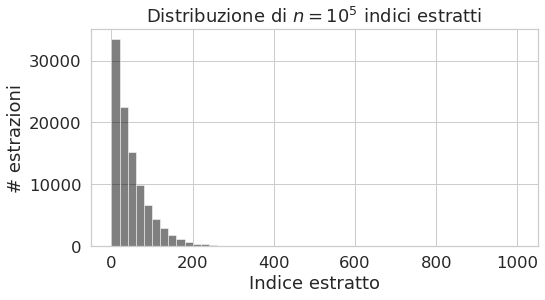

Elemento più frequente nell'array:  0


In [36]:
idx = np.loadtxt("Results/hist.dat")

plt.figure(figsize=(8,4))
plt.title('Distribuzione di $n=10^5$ indici estratti')
plt.hist(idx, bins=50, color='black', alpha=0.5, range=(0,1000))
plt.xlabel('Indice estratto')
plt.ylabel('# estrazioni')
plt.show()

print("Elemento più frequente nell'array: ", int(mode(idx)))

- una volta selezionati due elementi in questo modo, essi vengono incrociati tramite un operatore di crossover, all'interno del quale viene selezionata casualmente una posizione in cui effettuare un taglio nelle code. Gli elementi contenuti nella coda prima del taglio vengono conservati, quelli successivi al taglio vengono ricollocati nell'ordine in cui compaiono all'interno del genitore "partner". Questa operazione viene eseguita con una probabilità $p_c = 0.8$. I cromosomi ottenuti tramite questo procedimento vengono "appesi" alla popolazione `_son[]`, corrispondente alla nuova generazione di individui. In ogni rinnovamento di generazione ho ripetuto $N_{pop}/2$ volte questa operazione, così da ottenere, al termine del processo, una popolazione completa di cardinalità uguale a quella precedente;
- ottenuta dunque la popolazione dei figli, applico a ciascun elemento della popolazione una sequenza di quattro mutazioni genetiche, ciascuna di esse con probabilità $p_m=0.06$ di verificarsi. Ho implementato le seguenti mutazioni:
    1. `shuffle_mutation`: estraggo casualmente un indice della coda e rimescolo casualmente quattro elementi a partire da quell'indice;
    2. `inverse_mutation`: estraggo casualmente due indici all'interno della coda e inverto l'ordine in cui compaiono gli elementi compresi tra i due indici;
    3. `translation_mutation`: lancio un dado a sei facce. Traslo tutti gli elementi della coda del valore casuale estratto;
    4. `swap_mutation`: estraggo casualmente due indici nella coda. Inverto la posizione dei geni contenuti in quelle posizioni.

Nell'implementazione degli operatori di mutazione ho fatto uso di una funzione di _periodic boundary condition_ all'interno delle code.

#### Esecuzione dell'algoritmo

Ho eseguito l'algoritmo su un circuito composto da città estratte casualmente lungo una circonferenza di raggio uno, un altro composto da città disposte casualmente all'interno di un quadrato di lato uno e, infine, ho voluto mettere alla prova l'algoritmo su un circuito composto da cento città disposte lungo lo stesso cerchio di raggio uno.

### Commesso viaggiatore sulla circonferenza

Ho eseguito una simulazione di $N_{gen}=1000$ generazioni, considerando una popolazione di $N_{pop}=1000$ individui.

In [3]:
x_first = [] 
y_first = []

for i in range(len(chromo1)):
    x_first.append(cities.T[0][chromo1[i]-1])
    y_first.append(cities.T[1][chromo1[i]-1])
    
x_first.append(cities.T[0][chromo1[0]-1])
y_first.append(cities.T[1][chromo1[0]-1])

x_best = [] 
y_best = []

for i in range(len(chromo2)):
    x_best.append(cities.T[0][chromo2[i]-1])
    y_best.append(cities.T[1][chromo2[i]-1])
    
x_best.append(cities.T[0][chromo2[0]-1])
y_best.append(cities.T[1][chromo2[0]-1])

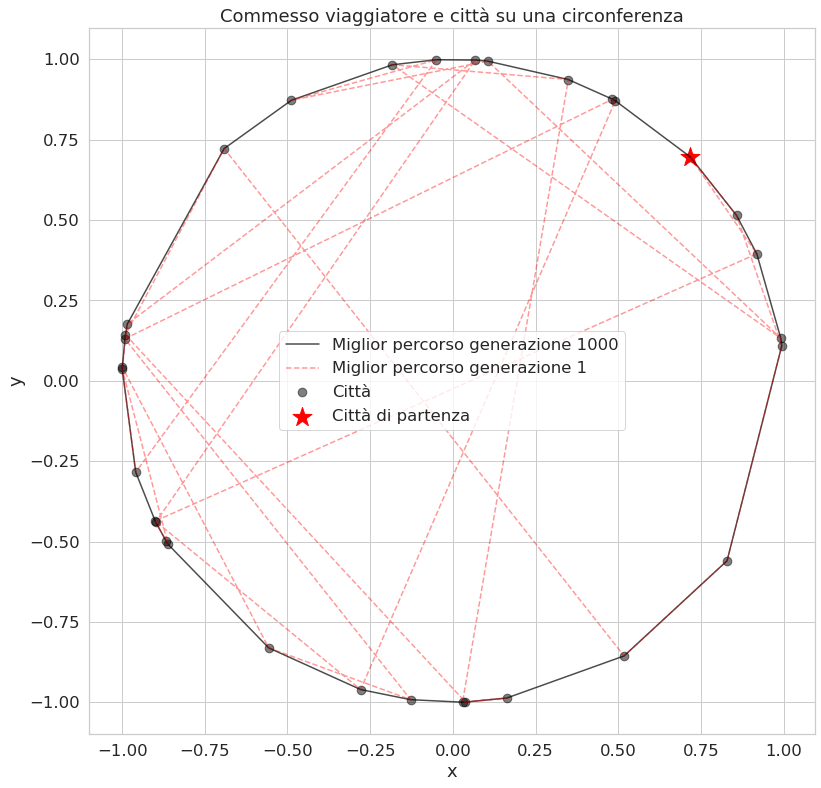

In [11]:
plt.figure(figsize=(13,13))
plt.title("Commesso viaggiatore e città su una circonferenza")
plt.scatter(cities.T[0], cities.T[1], marker='.', s=300, alpha=0.5, color='black', linestyle='-', label='Città')
plt.scatter(cities.T[0][0], cities.T[1][0], marker='*', s=400, alpha=1, color='red', linestyle='-', label='Città di partenza')
plt.plot(x_best, y_best, linestyle='-', alpha=0.7, color='black', label='Miglior percorso generazione 1000')
plt.plot(x_first, y_first, linestyle='--', alpha=0.4, color='red', label='Miglior percorso generazione 1')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('on_circle.png')

plt.show()

__Figura 1:__ in rosso, il miglior percorso della popolazione corrispondente alla prima generazione dell'algoritmo. In nero, il miglior percorso della popolazione corrispondente all'ultima generazione dell'algoritmo. Si nota il netto miglioramento della performance. Riporto in seguito il valore del costo relativo ai migliori cromosomi della prima e dell'ultima generazione.

$$ L_{best}^{(1)}=27.8692 $$

$$ L_{best}^{(1000)}=6.2403 $$

A seguire, un grafico in cui ho rappresentato i valori di funzione di costo $L$ calcolata sul miglior elemento della popolazione e media dei valori di $L$ sulla prima metà della popolazione riordinata (la miglior metà).

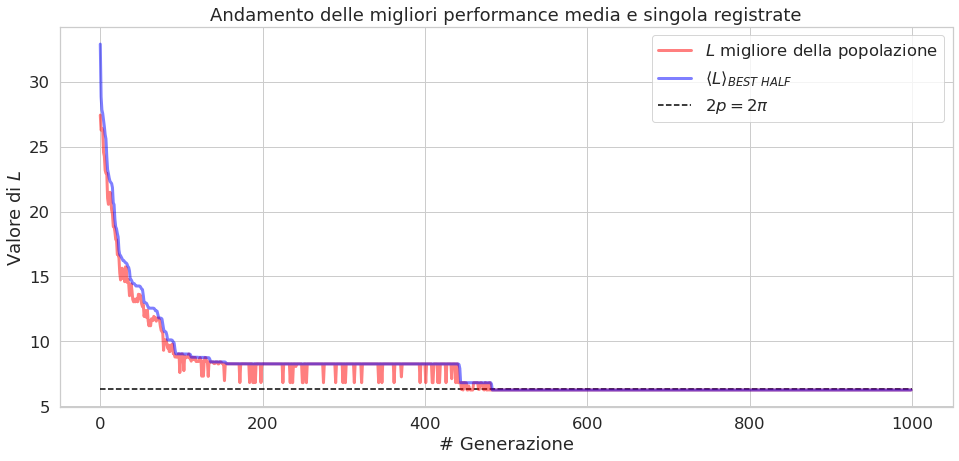

In [10]:
plt.figure(figsize=(16,7))

plt.title("Andamento delle migliori performance media e singola registrate")
plt.plot(best_cir, linewidth=3, label="$L$ migliore della popolazione", alpha=0.5, color='red')
plt.plot(half_cir, linewidth=3, label=r'$\langle L \rangle _{BEST\,\,HALF}$', alpha=0.5, color='blue')
plt.hlines(2*np.pi, 0, 1000, color='black', linestyle='--', label=r'$2p=2\pi$')
plt.xlabel('# Generazione')
plt.ylabel('Valore di $L$')
plt.legend()
plt.show()

__Figura 2:__ in rosso, andamento del valore della funzione di costo valutata sul miglior individuo della popolazione in ogni generazione. In blu, media dei valori della funzione di costo calcolata considerando la metà migliore della popolazione. In nero, il valore teorico del perimetro di un cerchio di raggio uno. Notiamo che, dall'epoca circa 500 in avanti, l'algoritmo trova un risultato ottimo che si conserva anche nelle generazioni successive.

### Commesso viaggiatore nel quadrato

Ho eseguito una simulazione di $N_{gen}=1000$ generazioni, considerando una popolazione di $N_{pop}=1000$ individui.

In [13]:
cities = np.loadtxt("Results/square_circuit.dat")

x_first = [] 
y_first = []

for i in range(len(square1)):
    x_first.append(cities.T[0][square1[i]-1])
    y_first.append(cities.T[1][square1[i]-1])
    
x_first.append(cities.T[0][square1[0]-1])
y_first.append(cities.T[1][square1[0]-1])

x_best = [] 
y_best = []

for i in range(len(square2)):
    x_best.append(cities.T[0][square2[i]-1])
    y_best.append(cities.T[1][square2[i]-1])
    
x_best.append(cities.T[0][square2[0]-1])
y_best.append(cities.T[1][square2[0]-1])

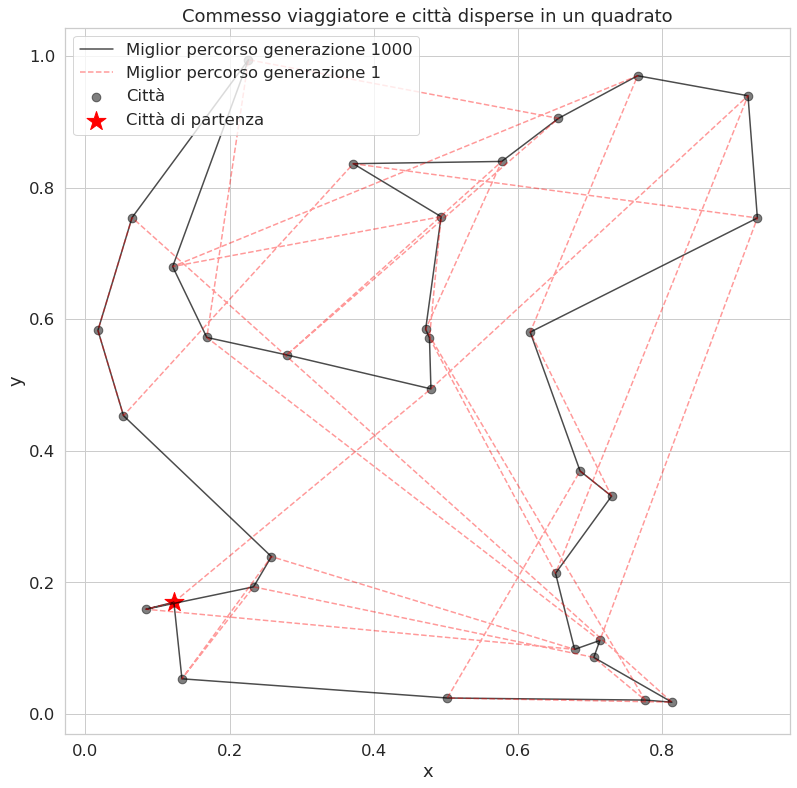

In [15]:
plt.figure(figsize=(13,13))
plt.title("Commesso viaggiatore e città disperse in un quadrato")
plt.scatter(cities.T[0], cities.T[1], marker='.', s=300, alpha=0.5, color='black', linestyle='-', label='Città')
plt.scatter(cities.T[0][0], cities.T[1][0], marker='*', s=400, alpha=1, color='red', linestyle='-', label='Città di partenza')
plt.plot(x_best, y_best, linestyle='-', alpha=0.7, color='black', label='Miglior percorso generazione 1000')
plt.plot(x_first, y_first, linestyle='--', alpha=0.4, color='red', label='Miglior percorso generazione 1')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('on_square.png')

plt.show()

__Figura 3:__ in rosso, il miglior percorso della popolazione corrispondente alla prima generazione dell'algoritmo. In nero, il miglior percorso della popolazione corrispondente all'ultima generazione dell'algoritmo. Si nota anche in questo caso il netto miglioramento della performance, sebbene non sia ancora stato raggiunta la soluzione migliore (come possiamo valutare facendo un confronto con i risultati dell'esercitazione dieci). Riporto in seguito il valore del costo relativo ai migliori cromosomi della prima e dell'ultima generazione.

$$ L_{best}^{(1)}=13.6005 $$

$$ L_{best}^{(1000)}=4.99095 $$

A seguire, un grafico in cui ho rappresentato i valori di funzione di costo $L$ calcolata sul miglior elemento della popolazione e media dei valori di $L$ sulla prima metà della popolazione riordinata (la miglior metà).

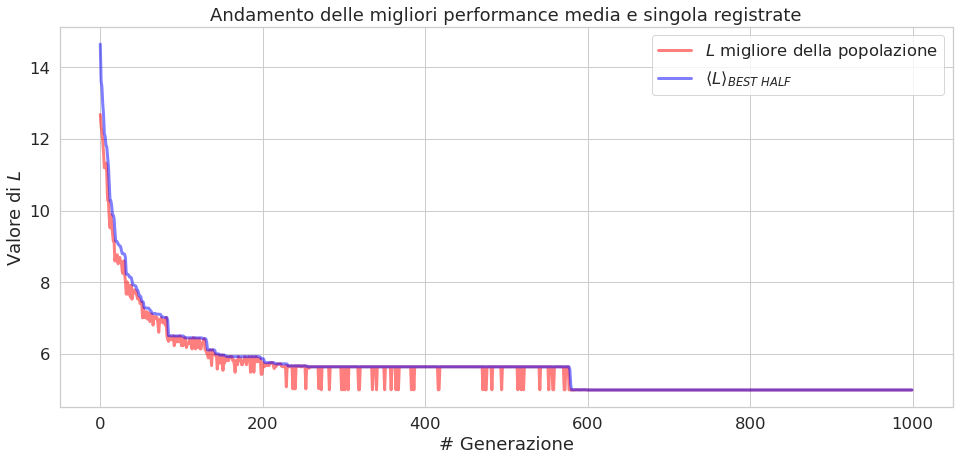

In [16]:
plt.figure(figsize=(16,7))

plt.title("Andamento delle migliori performance media e singola registrate")
plt.plot(best_sq, linewidth=3, label="$L$ migliore della popolazione", alpha=0.5, color='red')
plt.plot(half_sq, linewidth=3, label=r'$\langle L \rangle _{BEST\,\,HALF}$', alpha=0.5, color='blue')
plt.xlabel('# Generazione')
plt.ylabel('Valore di $L$')
plt.legend()
plt.show()

__Figura 4:__ in rosso, andamento del valore della funzione di costo valutata sul miglior individuo della popolazione in ogni generazione. In blu, media dei valori della funzione di costo calcolata considerando la metà migliore della popolazione. Vediamo come la soluzione ottimale venga conservata sin da poco prima dell'epoca seicento. Osservando la figura 3 possiamo notare come non sia ancora stata raggiunta la soluzione migliore, cosa che invece possiamo dire nel caso del circuito circolare. Per migliorare i risultati nel quadrato avrei potuto prolungare la simulazione, oppure aumentare il numero di individui nella popolazione. Ho voluto lasciare inalterati tali valori per effettuare un confronto diretto e "ad armi pari" con il caso del circuito disposto sulla circonferenza. 

---

In secondo luogo, ho voluto mantenere invariati i parametri del GA per poter confrontare i risultati ottenuti in questa esercitazione e nella prossima. 

### Metto alla prova l'algoritmo su un circuito circolare sul quale dispongo cento città

In [44]:
chromo1 = np.loadtxt("Results/CIRCLE_initial.dat", dtype='int')
chromo2 = np.loadtxt("Results/CIRCLE_final.dat", dtype='int')
cities = np.loadtxt("Results/bigcircle.dat")

In [45]:
x_first = [] 
y_first = []

for i in range(len(chromo1)):
    x_first.append(cities.T[0][chromo1[i]-1])
    y_first.append(cities.T[1][chromo1[i]-1])
    
x_first.append(cities.T[0][chromo1[0]-1])
y_first.append(cities.T[1][chromo1[0]-1])

x_best = [] 
y_best = []

for i in range(len(chromo2)):
    x_best.append(cities.T[0][chromo2[i]-1])
    y_best.append(cities.T[1][chromo2[i]-1])
    
x_best.append(cities.T[0][chromo2[0]-1])
y_best.append(cities.T[1][chromo2[0]-1])

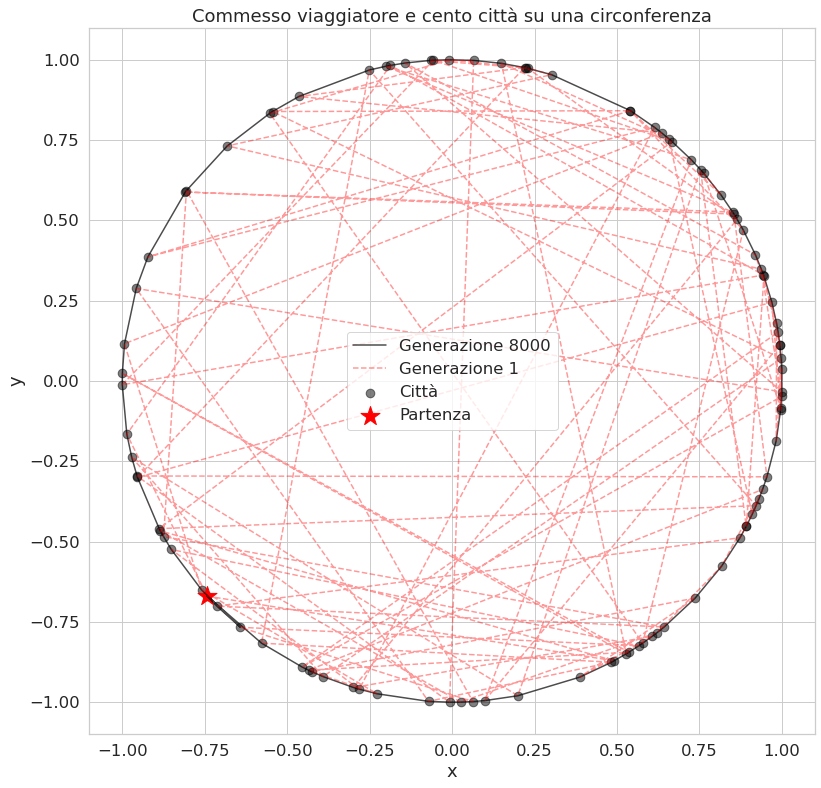

In [48]:
plt.figure(figsize=(13,13))
plt.title("Commesso viaggiatore e cento città su una circonferenza")
plt.scatter(cities.T[0], cities.T[1], marker='.', s=300, alpha=0.5, color='black', linestyle='-', label='Città')
plt.scatter(cities.T[0][0], cities.T[1][0], marker='*', s=400, alpha=1, color='red', linestyle='-', label='Partenza')
plt.plot(x_best, y_best, linestyle='-', alpha=0.7, color='black', label='Generazione 8000')
plt.plot(x_first, y_first, linestyle='--', alpha=0.4, color='red', label='Generazione 1')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('on_CIRCLE.png')

plt.show()

__Figura 5:__ in rosso, percorso corrispondente al miglior individuo della prima generazione. In nero, percorso corrispondente al miglior individuo dell'ultima generazione. Per poter raggiungere questo risultato senza cambiare la dimensione della popolazione ho dovuto compiere simulazioni molto più lunghe. In alternativa, avrei potuto aumentare il numero di cromosomi della popolazione.